# 03. Feature Engineering

## Objectives
- Create domain-specific feature interactions
- Aggregate features from external tables (bureau, previous applications)
- Handle missing values strategically
- Feature selection
- Prepare final dataset for modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Libraries loaded!")

Libraries loaded!


## 1. Load Cleaned Data

In [2]:
# Load cleaned application data
df = pd.read_csv('../../data/processed/application_train_cleaned.csv')

print(f"Shape: {df.shape}")
print(f"Default rate: {df['TARGET'].mean():.4%}")

# Load external tables
data_dir = Path('../../data/raw/home-credit-default-risk')
df_bureau = pd.read_csv(data_dir / 'bureau.csv')
df_bureau_balance = pd.read_csv(data_dir / 'bureau_balance.csv')
df_previous = pd.read_csv(data_dir / 'previous_application.csv')
df_pos_cash = pd.read_csv(data_dir / 'POS_CASH_balance.csv')
df_credit_card = pd.read_csv(data_dir / 'credit_card_balance.csv')
df_installments = pd.read_csv(data_dir / 'installments_payments.csv')

Shape: (307511, 125)
Default rate: 8.0729%


## 2. Domain-Specific Feature Interactions

In [3]:
print("Creating interaction features...\n")

# Financial ratios
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['ANNUITY_CREDIT_RATIO'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['GOODS_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']

# Employment ratios
df['EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_PER_FAMILY_MEMBER'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['CREDIT_PER_PERSON'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']

# External source combinations
df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['EXT_SOURCE_MAX'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1)
df['EXT_SOURCE_MIN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1)
df['EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['EXT_SOURCE_MUL'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# Document flags
doc_cols = [col for col in df.columns if 'FLAG_DOCUMENT' in col]
df['DOCUMENT_COUNT'] = df[doc_cols].sum(axis=1)

# Contact flags
contact_cols = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']
df['CONTACT_COUNT'] = df[contact_cols].sum(axis=1)

# Region flags
region_cols = ['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
               'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']
df['REGION_MISMATCH_COUNT'] = df[region_cols].sum(axis=1)

print(f"""✅ Feature creation complete:
   • Financial ratios: 5 features
   • Employment & family: 3 features
   • External source combinations: 5 features
   • Flag aggregations: 2 features (documents, contacts)
   • Region features: 1 feature

New shape: {df.shape}
Features added: {df.shape[1] - 122}""")

Creating interaction features...

✅ Feature creation complete:
   • Financial ratios: 5 features
   • Employment & family: 3 features
   • External source combinations: 5 features
   • Flag aggregations: 2 features (documents, contacts)
   • Region features: 1 feature

New shape: (307511, 141)
Features added: 19


## 3. Bureau Aggregations

In [4]:
print("Creating bureau aggregations...\n")

# Numeric aggregations
bureau_agg = df_bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['mean', 'min', 'max'],
    'CREDIT_DAY_OVERDUE': ['mean', 'max'],
    'DAYS_CREDIT_ENDDATE': ['mean', 'min'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'sum', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum', 'max'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SK_ID_BUREAU': 'count'
})

# Flatten column names
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]
bureau_agg = bureau_agg.reset_index()

# Categorical aggregations
bureau_cat = df_bureau.groupby('SK_ID_CURR').agg({
    'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(),
    'CREDIT_TYPE': 'nunique'
}).reset_index()
bureau_cat.columns = ['SK_ID_CURR', 'BUREAU_ACTIVE_COUNT', 'BUREAU_CREDIT_TYPE_COUNT']

# Merge
bureau_agg = bureau_agg.merge(bureau_cat, on='SK_ID_CURR', how='left')

print(f"Bureau aggregations shape: {bureau_agg.shape}")
print(f"Features created: {bureau_agg.shape[1] - 1}")

# Merge with main dataframe
df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')
print(f"\nAfter bureau merge: {df.shape}")

Creating bureau aggregations...

Bureau aggregations shape: (305811, 25)
Features created: 24

After bureau merge: (307511, 165)


## 4. Bureau Balance Aggregations

In [5]:
print("Creating bureau balance aggregations...\n")

# Merge bureau with bureau_balance to get SK_ID_CURR
df_bb = df_bureau_balance.merge(df_bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on='SK_ID_BUREAU', how='left')

# Aggregations
bb_agg = df_bb.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['mean', 'max'],
    'STATUS': lambda x: (x == 'C').sum()  # Count of closed credits
}).reset_index()

bb_agg.columns = ['SK_ID_CURR', 'BB_MONTHS_BALANCE_MEAN', 'BB_MONTHS_BALANCE_MAX', 'BB_STATUS_CLOSED_COUNT']

# Merge
df = df.merge(bb_agg, on='SK_ID_CURR', how='left')
print(f"After bureau balance merge: {df.shape}")

Creating bureau balance aggregations...

After bureau balance merge: (307511, 168)


## 5. Previous Application Aggregations

In [6]:
print("Creating previous application aggregations...\n")

# Numeric aggregations
prev_agg = df_previous.groupby('SK_ID_CURR').agg({
    'AMT_ANNUITY': ['mean', 'max', 'min'],
    'AMT_APPLICATION': ['mean', 'max', 'sum'],
    'AMT_CREDIT': ['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT': ['mean', 'max'],
    'AMT_GOODS_PRICE': ['mean', 'max'],
    'HOUR_APPR_PROCESS_START': ['mean'],
    'RATE_DOWN_PAYMENT': ['mean', 'max'],
    'DAYS_DECISION': ['mean', 'min'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'SK_ID_PREV': 'count'
})

prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]
prev_agg = prev_agg.reset_index()

# Categorical aggregations
prev_cat = df_previous.groupby('SK_ID_CURR').agg({
    'NAME_CONTRACT_STATUS': lambda x: (x == 'Approved').sum(),
    'NAME_CONTRACT_TYPE': 'nunique'
}).reset_index()
prev_cat.columns = ['SK_ID_CURR', 'PREV_APPROVED_COUNT', 'PREV_CONTRACT_TYPE_COUNT']

prev_agg = prev_agg.merge(prev_cat, on='SK_ID_CURR', how='left')

# Approval rate
prev_agg['PREV_APPROVAL_RATE'] = prev_agg['PREV_APPROVED_COUNT'] / prev_agg['PREV_SK_ID_PREV_COUNT']

print(f"Previous application aggregations: {prev_agg.shape}")

# Merge
df = df.merge(prev_agg, on='SK_ID_CURR', how='left')
print(f"After previous applications merge: {df.shape}")

Creating previous application aggregations...

Previous application aggregations: (338857, 25)
After previous applications merge: (307511, 192)


## 6. Credit Card Balance Aggregations

In [7]:
print("Creating credit card balance aggregations...\n")

cc_agg = df_credit_card.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': ['mean', 'max', 'sum'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 'max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['mean', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['mean', 'sum'],
    'AMT_PAYMENT_CURRENT': ['mean', 'sum'],
    'CNT_DRAWINGS_ATM_CURRENT': ['mean', 'sum'],
    'SK_DPD': ['mean', 'max'],
    'SK_DPD_DEF': ['mean', 'max']
})

cc_agg.columns = ['CC_' + '_'.join(col).upper() for col in cc_agg.columns]
cc_agg = cc_agg.reset_index()

# Credit utilization
cc_agg['CC_UTILIZATION_RATIO'] = cc_agg['CC_AMT_BALANCE_MEAN'] / cc_agg['CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN']

print(f"Credit card aggregations: {cc_agg.shape}")

df = df.merge(cc_agg, on='SK_ID_CURR', how='left')
print(f"After credit card merge: {df.shape}")

Creating credit card balance aggregations...

Credit card aggregations: (103558, 19)
After credit card merge: (307511, 210)


## 7. POS Cash Balance Aggregations

In [8]:
print("Creating POS cash balance aggregations...\n")

pos_agg = df_pos_cash.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['mean', 'max'],
    'CNT_INSTALMENT': ['mean', 'sum'],
    'CNT_INSTALMENT_FUTURE': ['mean', 'sum'],
    'SK_DPD': ['mean', 'max'],
    'SK_DPD_DEF': ['mean', 'max']
})

pos_agg.columns = ['POS_' + '_'.join(col).upper() for col in pos_agg.columns]
pos_agg = pos_agg.reset_index()

print(f"POS cash aggregations: {pos_agg.shape}")

df = df.merge(pos_agg, on='SK_ID_CURR', how='left')
print(f"After POS cash merge: {df.shape}")

Creating POS cash balance aggregations...

POS cash aggregations: (337252, 11)
After POS cash merge: (307511, 220)


## 8. Installments Payments Aggregations

In [9]:
print("Creating installments payments aggregations...\n")

# Calculate payment differences
df_installments['PAYMENT_DIFF'] = df_installments['AMT_PAYMENT'] - df_installments['AMT_INSTALMENT']
df_installments['PAYMENT_RATIO'] = df_installments['AMT_PAYMENT'] / df_installments['AMT_INSTALMENT']
df_installments['DAYS_DIFF'] = df_installments['DAYS_ENTRY_PAYMENT'] - df_installments['DAYS_INSTALMENT']
df_installments['LATE_PAYMENT'] = (df_installments['DAYS_DIFF'] > 0).astype(int)

inst_agg = df_installments.groupby('SK_ID_CURR').agg({
    'AMT_INSTALMENT': ['mean', 'sum', 'max'],
    'AMT_PAYMENT': ['mean', 'sum', 'max'],
    'PAYMENT_DIFF': ['mean', 'sum'],
    'PAYMENT_RATIO': ['mean', 'min'],
    'DAYS_DIFF': ['mean', 'max'],
    'LATE_PAYMENT': ['sum', 'mean']
})

inst_agg.columns = ['INST_' + '_'.join(col).upper() for col in inst_agg.columns]
inst_agg = inst_agg.reset_index()

print(f"Installments aggregations: {inst_agg.shape}")

df = df.merge(inst_agg, on='SK_ID_CURR', how='left')
print(f"After installments merge: {df.shape}")

Creating installments payments aggregations...

Installments aggregations: (339587, 15)
After installments merge: (307511, 234)


## 9. Handle Missing Values

In [10]:
print("Handling missing values...\n")

# Check missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Percentage', ascending=False)

print("Top 20 features with missing values:")
print(missing_df[missing_df['Missing_Count'] > 0].head(20))

# Drop columns with >70% missing
cols_to_drop = missing_df[missing_df['Missing_Percentage'] > 70].index.tolist()
print(f"\nDropping {len(cols_to_drop)} columns with >70% missing")
df = df.drop(columns=cols_to_drop)

print(f"Shape after dropping: {df.shape}")

Handling missing values...

Top 20 features with missing values:
                                  Missing_Count  Missing_Percentage
CC_AMT_PAYMENT_CURRENT_MEAN              246451           80.143800
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN         246371           80.117784
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN         246371           80.117784
BUREAU_AMT_ANNUITY_MEAN                  227502           73.981744
BUREAU_AMT_ANNUITY_MAX                   227502           73.981744
CC_UTILIZATION_RATIO                     221348           71.980515
CC_AMT_BALANCE_MEAN                      220606           71.739222
CC_SK_DPD_DEF_MEAN                       220606           71.739222
CC_SK_DPD_MAX                            220606           71.739222
CC_SK_DPD_MEAN                           220606           71.739222
CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN          220606           71.739222
CC_AMT_BALANCE_SUM                       220606           71.739222
CC_CNT_DRAWINGS_ATM_CURRENT_SUM          220606    

In [11]:
# Fill missing values
# Numeric: median for main features, 0 for aggregated features (no history)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Main application features
main_features = [col for col in numerical_cols if not any(x in col for x in ['BUREAU', 'PREV', 'CC', 'POS', 'INST', 'BB'])]
for col in main_features:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Aggregated features (NaN means no history)
agg_features = [col for col in numerical_cols if any(x in col for x in ['BUREAU', 'PREV', 'CC', 'POS', 'INST', 'BB'])]
for col in agg_features:
    if df[col].isnull().sum() > 0:
        df[col].fillna(0, inplace=True)

# Categorical: mode or 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
        df[col].fillna(mode_value, inplace=True)

print("\n✅ Missing values handled")
print(f"Remaining NaNs: {df.isnull().sum().sum()}")


✅ Missing values handled
Remaining NaNs: 0


## 10. Encode Categorical Features

In [12]:
print("Encoding categorical features...\n")

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {len(categorical_cols)}")

# Label encoding
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

print(f"✅ {len(categorical_cols)} categorical features encoded")
print(f"\nFinal shape: {df.shape}")

Encoding categorical features...

Categorical columns: 16
✅ 16 categorical features encoded

Final shape: (307511, 211)


## 11. Feature Correlation Analysis

Top 30 features correlated with TARGET:
EXT_SOURCE_MEAN               -0.221989
EXT_SOURCE_MAX                -0.196818
EXT_SOURCE_MIN                -0.185214
EXT_SOURCE_2                  -0.160295
EXT_SOURCE_3                  -0.155892
EXT_SOURCE_MUL                -0.109511
EXT_SOURCE_1                  -0.098887
BUREAU_DAYS_CREDIT_MEAN        0.083960
DAYS_BIRTH                     0.078239
AGE_YEARS                     -0.078239
BUREAU_DAYS_CREDIT_MIN         0.072869
INST_LATE_PAYMENT_MEAN         0.070507
CREDIT_GOODS_RATIO             0.069966
DAYS_EMPLOYED                  0.063368
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
EMPLOY_TO_BIRTH_RATIO         -0.057535
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_EDUCATION_TYPE            0.054699
CODE_GENDER                    0.054692
BUREAU_DAYS_CREDIT_MAX         0.052740
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
NAME_INCOME_TYPE               0.046829


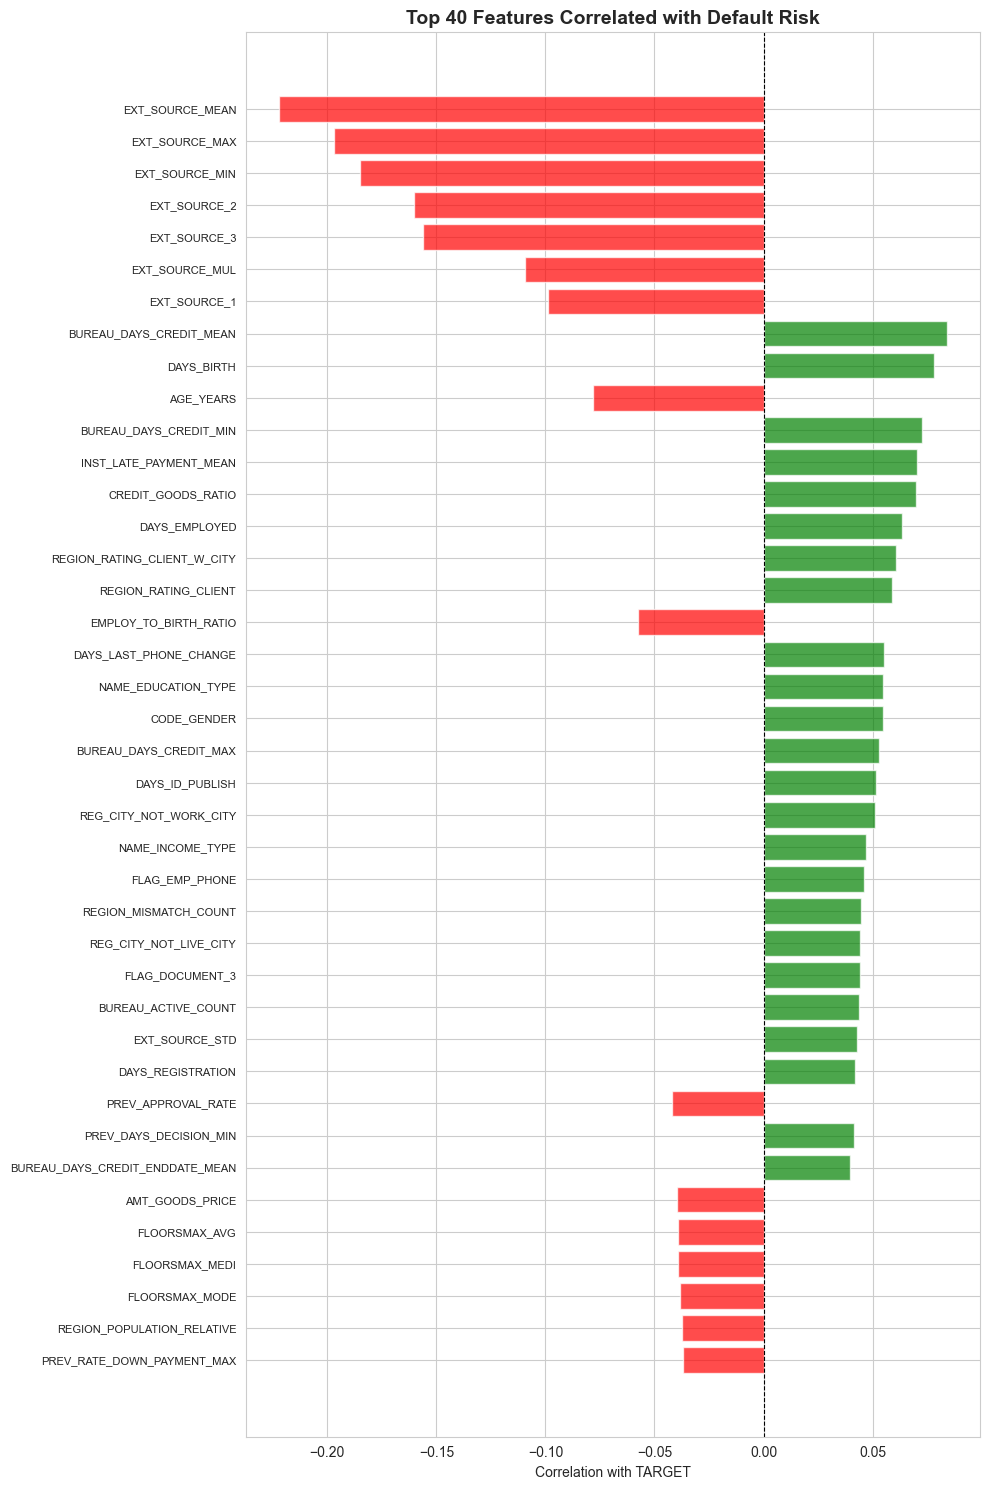

In [13]:
# Correlation with target
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('TARGET')
numerical_cols.remove('SK_ID_CURR')

correlations = df[numerical_cols].corrwith(df['TARGET']).sort_values(key=abs, ascending=False)

print("Top 30 features correlated with TARGET:")
print(correlations.head(30))

# Visualize
plt.figure(figsize=(10, 15))
top_corr = correlations.head(40)
colors = ['red' if x < 0 else 'green' for x in top_corr]
plt.barh(range(len(top_corr)), top_corr, color=colors, alpha=0.7)
plt.yticks(range(len(top_corr)), top_corr.index, fontsize=8)
plt.xlabel('Correlation with TARGET')
plt.title('Top 40 Features Correlated with Default Risk', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 12. Remove Highly Correlated Features

In [14]:
# Calculate correlation matrix
corr_matrix = df[numerical_cols].corr().abs()

# Select upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Highly correlated features to drop: {len(to_drop)}")
print(to_drop[:20] if len(to_drop) > 20 else to_drop)

# Drop
df = df.drop(columns=to_drop)
print(f"\nShape after dropping correlated features: {df.shape}")

Highly correlated features to drop: 46
['AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI']

Shape after dropping correlated features: (307511, 165)


## 13. Save Engineered Dataset

In [15]:
# Summary
print("=" * 60)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 60)
print(f"Final shape: {df.shape}")
print(f"Total features: {df.shape[1] - 2}")  # Exclude TARGET and SK_ID_CURR
print(f"Default rate: {df['TARGET'].mean():.4%}")
print(f"Missing values: {df.isnull().sum().sum()}")

print("\nFeature breakdown:")
print(f"  - Original features: ~122")
print(f"  - Interaction features: ~15")
print(f"  - Bureau features: {len([c for c in df.columns if 'BUREAU' in c or 'BB_' in c])}")
print(f"  - Previous app features: {len([c for c in df.columns if 'PREV' in c])}")
print(f"  - Credit card features: {len([c for c in df.columns if 'CC_' in c])}")
print(f"  - POS cash features: {len([c for c in df.columns if 'POS_' in c])}")
print(f"  - Installments features: {len([c for c in df.columns if 'INST_' in c])}")
print("=" * 60)

FEATURE ENGINEERING SUMMARY
Final shape: (307511, 165)
Total features: 163
Default rate: 8.0729%
Missing values: 0

Feature breakdown:
  - Original features: ~122
  - Interaction features: ~15
  - Bureau features: 26
  - Previous app features: 20
  - Credit card features: 0
  - POS cash features: 7
  - Installments features: 11


In [16]:
# Save
output_file = Path('../../data/processed/application_train_features.csv')
df.to_csv(output_file, index=False)

print(f"\n✅ Engineered features saved to: {output_file}")
print(f"File size: {output_file.stat().st_size / 1024**2:.2f} MB")

# Save feature names
feature_cols = [col for col in df.columns if col not in ['SK_ID_CURR', 'TARGET']]
with open('../../data/processed/feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_cols))

print(f"✅ Feature names saved: {len(feature_cols)} features")


✅ Engineered features saved to: ..\..\data\processed\application_train_features.csv
File size: 302.35 MB
✅ Feature names saved: 163 features


## Next Steps

✅ **Completed:**
- Domain-specific feature interactions
- Aggregations from all external tables
- Missing value handling
- Categorical encoding
- Correlation analysis
- Feature selection

⏭️ **Next:** Model Training (training/01_baseline_models.ipynb)
- Split data (train/validation/test)
- Handle imbalanced data (SMOTE)
- Train baseline models
- Compare performance